# Praxisteil

__Agenda__

1. Problemstellung
2. Daten
3. Zusammen Programmieren: Bayessches Lineares Modell
    1. Modell in pymc3 bauen
    2. Posterior Distribution of Parameters
    3. Posterior Predictive Checks
2. Zusammen Programmieren: Bayessches Hierarchisches Lineares Modell
    1. Modell in pymc3 bauen
    2. Posterior Distribution of Parameters
    3. Posterior Predictive Checks
    4. Modellvergleich
3. Aufgabe: Modellierung
    1. Modell in pymc3 bauen
    2. Posterior Distribution of Parameters    
    3. Posterior Predictive Checks
    

## Problemstellung

Du wurdest beauftragt den Absatz des Unternehmens vorherzusagen.

Als erfahrener Bayesianer machst du dich ans Werk und überlegst dir, was den größten Einfluss auf den Absatz haben könnte. Du stellst die Hypothese auf, dass der Preis wahrscheinlich den größten Einfluss hat. Diese Hypothese willst du mit einem ersten Modell überprüfen.

Die Daten hast du gequeried und aufbereitet.

## Daten

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('../data/dataset_1.csv')
df.head()

,Sales,Price,Store
0,48.484536,5.749164,0
1,43.640838,4.796067,0
2,48.609230,4.817825,0
3,45.924189,5.680656,0
4,57.832635,3.181501,0


## Bayessches Lineares Modell

Du stellst das folgende probabilistische Modell auf, das den Absatz als bedingte Normalverteilung beschreibt:

$$
\begin{align}
y|X\beta &\sim N(\mu,\epsilon) \\
y &\sim N(X\beta,\epsilon)
\end{align}
$$

oder in diesem Falle konkret:

$$
sales \sim N(\mu=\beta_0 + \beta_1 \times price,\epsilon)
$$

Es gilt die Parameter $\beta_0$ und $\beta_1$ zu schätzen. In der Bayesschen Statistik werden ALLE Unbekannten mit einer Verteilung über ihre möglichen, plausiblen Werte beschrieben. Diese wird A-Priori-Verteilung genannt. 

In diesem Falle gilt es also Verteilungen für $\beta_0$, $\beta_1$ und $\epsilon$ zu finden. Eine Möglichkeit wäre:

$$
\begin{align}
\beta_0 &= N(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_1 &= N(\mu_{\beta_0}, \sigma_{\beta_1}) \\
\epsilon &= |N(0, \sigma_{\epsilon})| \\
\end{align}
$$

### Modell in pymc3 bauen

Dieses Modell wird in pymc3 wie folgt gebaut:

In [17]:
import pymc3 as pm
import arviz as az
import numpy as np

import math
import warnings
warnings.filterwarnings('ignore')

In [18]:
pm.__version__

'3.10.0'

In [7]:
# Plotting functions
def plot_model_with_hdi(df,ppc,beta_0_est,beta_1_est):
    plt.figure()
    az.plot_hdi(df['Price'], ppc['sales_pred'],color='gray',figsize=(20,10))
    plt.plot(df['Price'],df['Sales'],'.b')
    plt.plot(df['Price'], beta_0_est + beta_1_est*df['Price'],c='k')
    plt.xlabel('Price')
    plt.ylabel('Sales')

In [ ]:
with pm.Model() as linear_model:
    
    # Hyperparameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=0, sd=50)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    #mu = pm.Deterministic('mu', beta_0 + beta_1*df['Price'])
    mu = beta_0 + beta_1*df['Price']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    # Trace
    trace_linear_model = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


### Posterior Distributions of Parameters

In [ ]:
# Analyze the results
#az.plot_trace(trace_linear_model)
az.plot_posterior(trace_linear_model) 

In [ ]:
az.summary(trace_linear_model)

In [ ]:
# The estamates of the parameters are the mean of all samples
beta_0_est = trace_linear_model['beta_0'].mean()
beta_1_est = trace_linear_model['beta_1'].mean()
eps_est = trace_linear_model['eps'].mean()

print(f'BAY beta_0_est: {beta_0_est}')
print(f'BAY beta_1_est: {beta_1_est}')

In [ ]:
# Compaison with MLE Estimate
b, m = np.polynomial.polynomial.polyfit(df['Price'], df['Sales'], 1)
print(f'MLE beta_0_est: {b}')
print(f'MLE beta_1_est: {m}')

### Posterior Predictive Check

In [ ]:
# Predict observations from the model by posterior predictive sampling
ppc_lm = pm.sample_posterior_predictive(trace_linear_model, model=linear_model, random_seed=58)

In [ ]:
# Plot fitted model with 94 CI
plot_model_with_hdi(df,ppc_lm,beta_0_est,beta_1_est)

In [ ]:
idata = az.from_pymc3(trace_linear_model, posterior_predictive=ppc_lm)
az.plot_ppc(idata)

## Bayessches Hierarchisches Lineares Modell

In [18]:
# Plotting
def plot_fitted_models_by_group(y,x,num_groups,group_idx,trace):
    
    # Get number of rows and columns to plot
    if num_groups<=3:
        num_cols = num_groups
    else:
        num_cols = 3
    num_rows = math.ceil(num_groups/3)

    # Set up plot
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20,10), sharex=True, sharey=True)
    ax = np.ravel(ax)

    # Plot each group
    x_range = np.linspace(x.min(), x.max(), 10)
    j = 0
    k = len(group_idx[group_idx==j])
    for i in range(num_groups):
        ax[i].scatter(x[j:k], y[j:k])
        ax[i].set_title(f"Group {i+1}", fontsize=15)
        
        alpha_m = trace['beta_0'][:,i].mean()
        beta_m = trace['beta_1'][:, i].mean()
        ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
                   label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
        
        j += (group_idx==i).sum()
        k += (group_idx==i).sum()

    # Set common x and y axis
    fig.text(0.5, 0.07, 'Price', ha='center', fontsize=20)
    fig.text(0.09, 0.5, 'Sales', va='center', rotation='vertical', fontsize=20)

### Modell in pymc3 bauen

In [19]:
# Centering for better convergence
df['Price_centered'] = df['Price'] - df['Price'].mean()

# Group variables
group_idx = df['Store']
num_groups = df['Store'].nunique()

with pm.Model() as hierarchical_linear_model:
    
    # Priors for beta_0 prior (Hyperprior)
    beta_0_mu = pm.Normal('beta_0_mu', mu=0, sd = 100)
    beta_0_sigma = pm.HalfNormal('beta_0_sigma', sd = 100)
    
    # Priors for beta_1 prior (Hyperprior)
    beta_1_mu = pm.Normal('beta_1_mu', mu=0, sd = 100)
    beta_1_sigma = pm.HalfNormal('beta_1_sigma', sd = 100)
    
    # Hyperparameters
    beta_0_scaled = pm.Normal('beta_0_scaled', mu=beta_0_mu, sd=beta_0_sigma, shape=num_groups)
    beta_1 = pm.Normal('beta_1', mu=beta_1_mu, sd=beta_1_sigma, shape=num_groups)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    mu = beta_0_scaled[group_idx] + beta_1[group_idx]*df['Price_centered']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    beta_0 = pm.Deterministic('beta_0', beta_0_scaled - beta_1 * df['Price'].mean())
    
    # Trace
    trace_hierarchical_linear_model = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0_scaled, beta_1_sigma, beta_1_mu, beta_0_sigma, beta_0_mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 22 seconds.


### Posterior Distributions of Parameters

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

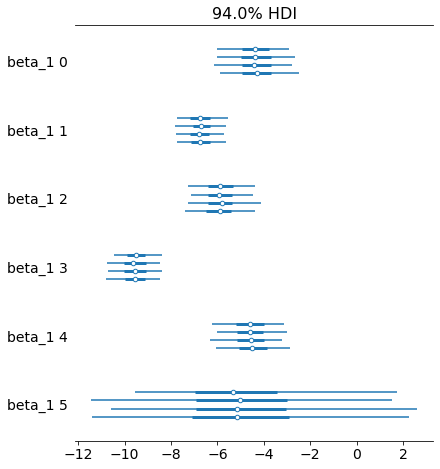

In [20]:
# Analyze the results
#az.plot_trace(trace_hierarchical_linear_model, var_names=['beta_0','beta_1'])
#az.plot_posterior(trace_hierarchical_linear_model) 
az.plot_forest(trace_hierarchical_linear_model, var_names='beta_1')

### Posterior Predictive Check

In [21]:
# Predict observations from the model by posterior predictive sampling
#ppc_lhm = pm.sample_posterior_predictive(trace_hierarchical_linear_model, model=hierarchical_linear_model, random_seed=58)

with hierarchical_linear_model:
    ppc_lhm = pm.sample_posterior_predictive(
        trace_hierarchical_linear_model, var_names=['beta_0','beta_1','sales_pred'], random_seed=58
    )

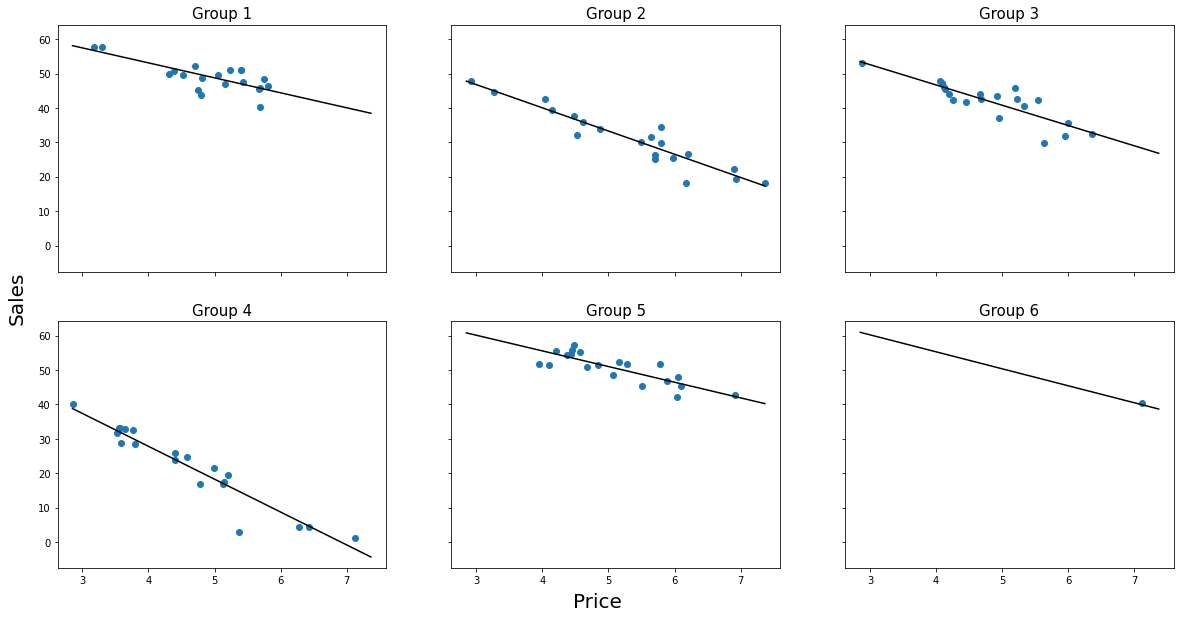

In [22]:
plot_fitted_models_by_group(df['Sales'],df['Price'],num_groups,group_idx,trace_hierarchical_linear_model)

<AxesSubplot:xlabel='sales_pred'>

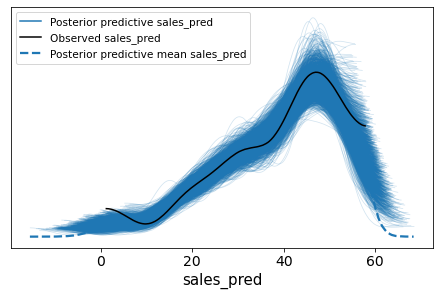

In [23]:
idata = az.from_pymc3(trace_hierarchical_linear_model, posterior_predictive=ppc_lhm)
az.plot_ppc(idata)

### Modellvergleich

In [28]:
cmp_df = az.compare({'Linear model': trace_linear_model,
                    'Hierarchical linear model': trace_hierarchical_linear_model},ic='waic')
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Hierarchical linear model,0,-262.027,10.2094,0,1,6.6352,0,True,log
Linear model,1,-397.122,2.9217,135.095,6.81118e-46,10.5996,9.65859,False,log


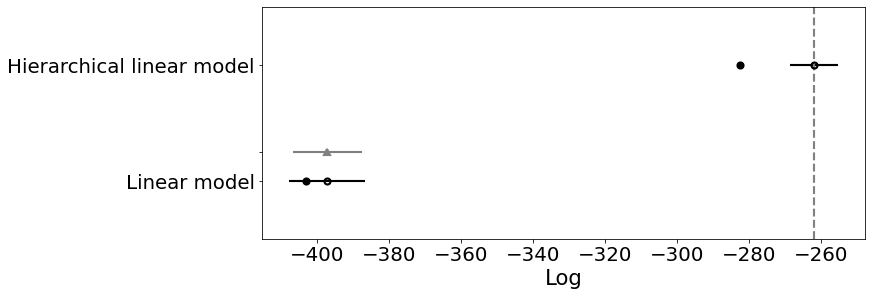

In [31]:
ax = az.plot_compare(cmp_df, figsize=(12, 4))

## Modellierung von Umsatz

# Code Snippets

Aus der visuellen Inspektion lässt sich bereits ein Zusammenhang vermuten. Du weißt aber, dass es sich nur um eine Stichprobe handelt und benötigst ein Modell, das die statistische Unsicherheit einer Stichprobenziehung berücksichtigt, um generalisierte Aussagen ableiten zu können.  

In [ ]:
# Plot functions

plt.figure(figsize=(20,10))
plt.scatter(df['Price'], df['Sales'])
plt.xlabel('Price', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.show()

In [ ]:
# Prior predictive sampling
ppc_lm = pm.sample_prior_predictive(model=linear_model, random_seed=58)

plt.figure(figsize=(20,10))
az.plot_hpd(df['Price'], ppc_lm['sales_pred'], credible_interval=0.5, color='gray')
az.plot_hpd(df['Price'], ppc_lm['sales_pred'], credible_interval=0.94, color='gray')
plt.xlabel('Price')
plt.ylabel('Sales')